In [1]:
import numpy as np
import cvxpy as cvx
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## Problem 1

In [2]:
# filter for convolution
h = np.exp(-0.5*np.array([-2, -1, 0, 1, 2])**2)

# Constants and arrays
L = 5
N = 100
x = np.zeros(N)
mean = 0
sigma = 0.02

# Modifying signal to be more interesting
x[9] = 1
x[12] = -1
x[49] = 0.3
x[70] = -0.2

In [3]:
def blur(x, h, N):
    y = np.zeros((N))
    for j in range(N):
        tot = 0
        for i in range(len(h)):
            tot += x[j - i]*h[i]
        y[j] = tot
    return y
def noise(y, mean, sigma):
    z = np.random.normal(mean, sigma**2, len(y))
    return y + z
def implicit2explicit(h, N):
    B = np.zeros((N,N))
    B[0,0] = h[0]
    B[-1,0] = h[1]
    B[-2,0] = h[2]
    B[-3,0] = h[3]
    B[-4,0] = h[4]
    for i in range(1,N):
        B[:,i] = np.roll(B[:,i-1], 1)
    return B

In [4]:
# Apply blur to x
y = blur(x, h, N)

# Apply noise
y = noise(y, mean, sigma)

# Extract convolution into matrix form
B = implicit2explicit(h, N)

## Problem 2

In [7]:
# defining our variables for cvxpy
x_val = cvx.Variable(N)
epsilon = sigma*N**(0.5)

# defining the cost functions depending on the norm and dataset
obj1 = cvx.Minimize(cvx.norm(x_val, 1))

constrint1 = [cvx.norm(B@x_val - y, 2) <= epsilon]

# setting the problems in cvxpy
prob1 = cvx.Problem(obj1, constrint1)

# solving the problems
prob1.solve()

# printing the estimators for each problem
x_hat = x_val.value

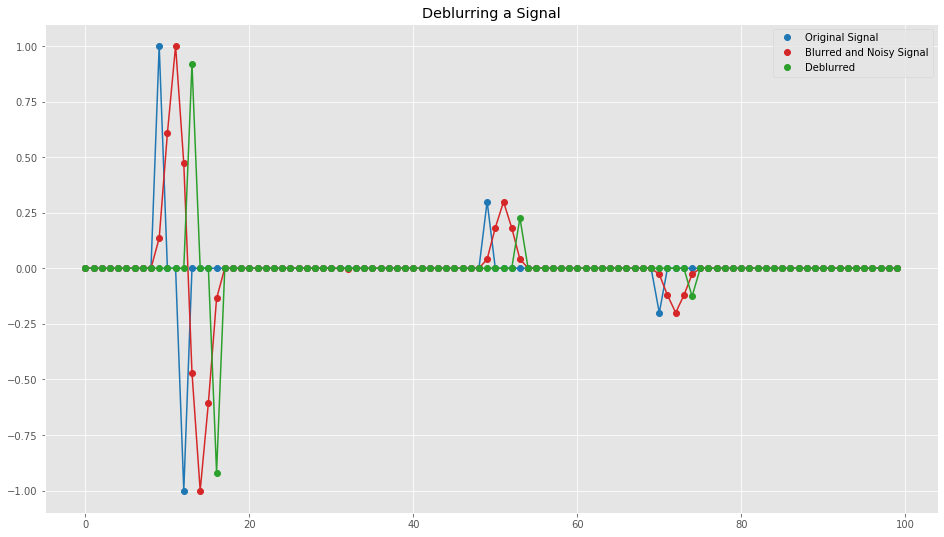

In [8]:
# Plotting all signals
plt.figure(figsize=(16,9))
axis = np.arange(N)
plt.plot(axis, x, 'o', label='Original Signal', color='tab:blue')
plt.plot(axis, x, '-', color='tab:blue')
plt.plot(axis, y, 'o', label='Blurred and Noisy Signal', color='tab:red')
plt.plot(axis, y, '-', color='tab:red')
plt.plot(axis, x_hat, 'o', label='Deblurred', color='tab:green')
plt.plot(axis, x_hat, '-', color='tab:green')
plt.title('Deblurring a Signal')
plt.legend()
plt.show()

## Problem 3

In [9]:
def get_dual():
    obj = cvx.Minimize(cvx.norm(x_val, 1))
    constraints = [cvx.norm(B@x_val - y, 2)**2 <= epsilon**2]
    prob = cvx.Problem(obj, constraints)
    prob.solve()

    return constraints[0].dual_value

# get dual variable (custome to this problem)
lam = get_dual()
print(f'Lambda value: {lam}')

# objective function
obj = cvx.Minimize(cvx.norm(x_val, 1) + lam*cvx.norm(B@x_val - y, 2)**2)

# Set up problem and solve
prob = cvx.Problem(obj)
prob.solve()

Lambda value: 3.851192935639652


2.34639873647197

## Number 4

In [15]:
def cconv(x,h,N, adjoint):
    x_f = np.fft.fft(x)
    h_f = np.fft.fft(h, n=N)
    if adjoint == True:
        h_f = h_f.conj()
    z_test = np.fft.ifft(x_f * h_f)
    return z_test
def test_adjoint(A, A_adj):
    # changing shapes
    A = np.expand_dims(A, axis=1)
    A_adj = np.expand_dims(A_adj, axis=1)

    # simulating n times with different values
    res = 0
    n = 100
    for i in range(n):
        # random variables
        # dont think this is correct - they are constants but the dimensions would not seem to match otherwise?
        x = 1000*np.random.rand() 
        y = 1000*np.random.rand()

        # evaluating equation
        out1 = np.dot(A*x, y)
        out2 = np.dot(x, A_adj*y)
        res += np.mean(out1.real - out2.real)
    return res/n

In [16]:
# Using FFT for finding B
B_conv_adj = cconv(x,h,N, adjoint=True)
B_conv = cconv(x,h,N, adjoint=False)

Text(0.5, 1.0, 'Convolution via FFT')

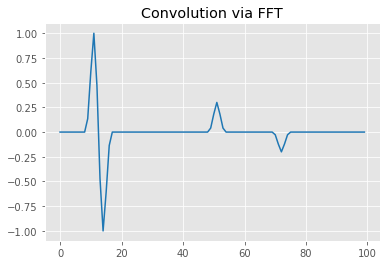

In [17]:
plt.plot(B_conv, color='tab:blue')
plt.title('Convolution via FFT')

Text(0.5, 1.0, 'Convolution via Function')

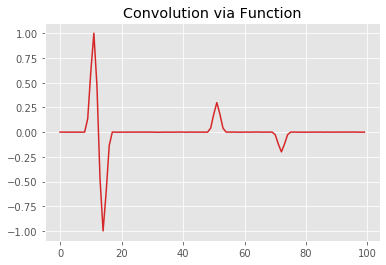

In [18]:
plt.plot(y, color='tab:red')
plt.title('Convolution via Function')

In [19]:
res = test_adjoint(B_conv, B_conv_adj)
print(f'Difference between B and B adjoint: {res}')

Difference between B and B adjoint: 1.71250486194663e-13


## Number 5

In [20]:
from pyunlocbox import functions, solvers
tau = 1/(2*lam)
f1 = functions.norm_l1(lambda_=tau)
f2 = functions.norm_l2(y=(1/np.sqrt(2))*y, A=(1/np.sqrt(2))*B)

step = 0.5 / np.linalg.norm(B, ord=2)**2
solver = solvers.forward_backward(step=step)

x0 = np.zeros(N)
ret = solvers.solve([f1, f2], x0, solver, rtol=1e-12, maxit=300)
ret['sol']

Solution found after 131 iterations:
    objective function f(sol) = 3.046327e-01
    stopping criterion: RTOL


array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.92005178,  0.        ,
        0.        , -0.91912855,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.22644634,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

Text(0.5, 1.0, '$1^{st}$ Order Solution')

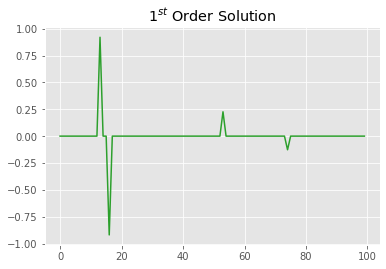

In [21]:
plt.plot(ret['sol'], color='tab:green')
plt.title(r'$1^{st}$ Order Solution')

In [22]:
obj1 = cvx.Minimize(1/(2*lam)*cvx.norm(x_val, 1) + 0.5*cvx.norm(B*x_val - y)**2)

# setting the problems in cvxpy
prob1 = cvx.Problem(obj1)

# solving the problems
prob1.solve()

# printing the estimators for each problem
print(f'Solution: {x_val.value}')
x_hat = x_val.value

Solution: [-3.71428059e-14 -3.42780168e-14 -5.04345298e-15  6.68783850e-15
 -1.20054501e-14 -2.74940609e-14 -3.00277827e-14 -2.44988348e-14
 -1.41575830e-14  9.83905154e-14  6.82508355e-13  2.72657924e-12
  1.75170347e-11  9.20049248e-01  2.83252831e-12 -2.65830676e-12
 -9.19126002e-01 -1.93556292e-11 -2.81695672e-12 -7.20926802e-13
 -1.62719328e-13 -5.94758974e-14 -3.37738096e-14 -2.39573436e-14
 -1.75156117e-14  2.32689283e-15  2.02745987e-14  2.28972879e-14
  2.71476048e-14  3.99422497e-14  3.29038071e-14  1.20199714e-14
 -4.51304594e-14 -1.23915122e-13 -1.52975350e-13 -1.06300445e-13
 -5.54433582e-14 -4.84016498e-14 -4.80886695e-14 -2.28464645e-14
  2.17430513e-14  4.44078092e-14  1.68267142e-14 -2.84736865e-14
 -1.21227485e-14  1.18919328e-14  9.16378223e-16 -8.47215147e-15
 -5.20689577e-15  7.74018108e-14  5.54233949e-13  2.18408217e-12
  9.67081823e-12  2.26446356e-01  9.36466312e-12  2.17729937e-12
  6.09241584e-13  1.46012443e-13  5.83492011e-14  2.09995741e-14
 -3.71371890e-1

Text(0.5, 1.0, 'Simple Solver Prob. 5')

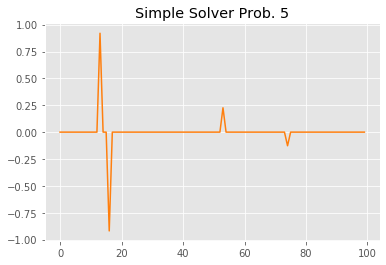

In [23]:
plt.plot(x_hat, color='tab:orange')
plt.title('Simple Solver Prob. 5')